In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_addons as tfa
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix
import seaborn as sns

from datetime import datetime

print(tf.__version__)
tf.config.list_physical_devices('GPU')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2.9.1
1 Physical GPUs, 1 Logical GPUs


2022-11-19 20:19:31.131094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 20:19:31.135052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 20:19:31.135228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 20:19:31.135932: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
(ds_train, ds_test, ds_validation), ds_info = tfds.load(
    'eurosat/all',
    split=['train[:80%]','train[80%:90%]','train[90%:100%]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [3]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['sparse_categorical_accuracy']
    val_accuracy = training_history.history['val_sparse_categorical_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.savefig(fname="resnet50/resnet50 history"+current_time,dpi=300)

In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return image[:,:,1:4]/28002., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

ds_validation = ds_validation.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_validation = ds_validation.batch(128)
ds_validation = ds_validation.cache()

In [5]:
def preview_dataset(dataset):
    for image, label in dataset.take(20):
        print(image)
preview_dataset(ds_test)

tf.Tensor(
[[[[0.03614027 0.03346189 0.02842654]
   [0.03614027 0.03346189 0.02842654]
   [0.03431898 0.03353332 0.0267838 ]
   ...
   [0.03642597 0.03578316 0.03114063]
   [0.03710449 0.03664024 0.03192629]
   [0.03817584 0.03717592 0.03478323]]

  [[0.03614027 0.03346189 0.02842654]
   [0.03614027 0.03346189 0.02842654]
   [0.03431898 0.03353332 0.0267838 ]
   ...
   [0.03642597 0.03578316 0.03114063]
   [0.03710449 0.03664024 0.03192629]
   [0.03817584 0.03717592 0.03478323]]

  [[0.03599743 0.03356903 0.02764088]
   [0.03599743 0.03356903 0.02764088]
   [0.03567602 0.03349761 0.02789086]
   ...
   [0.03589029 0.03460467 0.02910506]
   [0.0356046  0.03524748 0.02917649]
   [0.03631883 0.03581887 0.0307478 ]]

  ...

  [[0.03942576 0.03792586 0.03453325]
   [0.03942576 0.03792586 0.03453325]
   [0.03710449 0.03749732 0.0316406 ]
   ...
   [0.04635383 0.04667524 0.04488965]
   [0.04467538 0.04553246 0.04285408]
   [0.04342547 0.04342547 0.04096136]]

  [[0.03842583 0.03764017 0.034390

tf.Tensor(
[[[[0.02696236 0.0161417  0.00860653]
   [0.02696236 0.0161417  0.00860653]
   [0.0273909  0.01635597 0.00839226]
   ...
   [0.02789086 0.01628455 0.00874938]
   [0.02749804 0.01660596 0.00885651]
   [0.02774802 0.01632026 0.00860653]]

  [[0.02696236 0.0161417  0.00860653]
   [0.02696236 0.0161417  0.00860653]
   [0.0273909  0.01635597 0.00839226]
   ...
   [0.02789086 0.01628455 0.00874938]
   [0.02749804 0.01660596 0.00885651]
   [0.02774802 0.01632026 0.00860653]]

  [[0.02735519 0.01610599 0.00860653]
   [0.02735519 0.01610599 0.00860653]
   [0.0273909  0.01628455 0.00860653]
   ...
   [0.02721234 0.01639169 0.00867795]
   [0.02703378 0.01667738 0.00878509]
   [0.02796229 0.01632026 0.00867795]]

  ...

  [[0.02756946 0.01617742 0.0088208 ]
   [0.02756946 0.01617742 0.0088208 ]
   [0.02689094 0.01592743 0.00910649]
   ...
   [0.02724805 0.01682023 0.00932076]
   [0.02746232 0.01653453 0.00899936]
   [0.02774802 0.01635597 0.00878509]]

  [[0.02792658 0.01632026 0.008892

2022-11-19 20:19:31.803415: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [6]:
#FLIP
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image
# AUGMENT COLOR
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.07)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_hue(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.062)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_saturation(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_saturation(image, lower=0.745, upper=1.25)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_brightness(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_brightness(image, 0.062)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_contrast(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_contrast(image, lower=0.85, upper=1.05)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
# ROTATE
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )
#INVERT
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.8:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

In [7]:
def augment_data(image,label):
  image=augment_flip(image)
  #image=augment_color(image)
  #image=augment_rotation(image)
  #image=augment_inversion(image)
  image=augment_hue(image)
  image=augment_saturation(image)
  image=augment_brightness(image)
  image=augment_contrast(image)


  return image,label

In [8]:
ds_train_augmented = ds_train.map(augment_data)

In [9]:
resnet = tf.keras.applications.resnet50.ResNet50(include_top = False,
                                                 input_shape = (64,64,3),
                                                 classes = 10)

model = tf.keras.models.Sequential(resnet)
model.add(tf.keras.layers.Dropout(0.8745))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

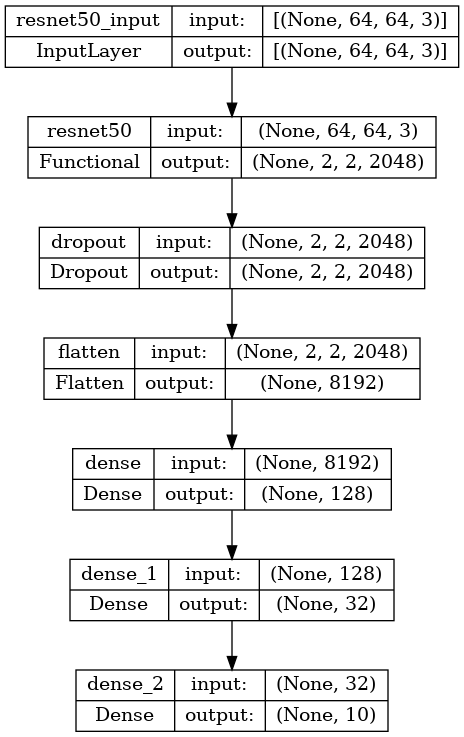

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.000015),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [11]:
history = model.fit(
    ds_train,
    epochs=100,
    validation_data=ds_validation,
    callbacks = tf.keras.callbacks.ModelCheckpoint(
        "resnet50/resnet50 epoch:{epoch:02d}-val_loss:{val_loss:.3f}",
        save_best_only = True,
        initial_value_threshold = 0.25
    )
)

Epoch 1/100


2022-11-19 20:19:37.862726: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-19 20:19:38.432202: W tensorflow/core/common_runtime/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


169/169 [==============================] - 28s 131ms/step - loss: 4.9762 - sparse_categorical_accuracy: 0.1531 - val_loss: 2.8602 - val_sparse_categorical_accuracy: 0.1107
Epoch 2/100
169/169 [==============================] - 20s 120ms/step - loss: 2.6009 - sparse_categorical_accuracy: 0.2894 - val_loss: 4.6336 - val_sparse_categorical_accuracy: 0.1119
Epoch 3/100
169/169 [==============================] - 20s 120ms/step - loss: 1.7762 - sparse_categorical_accuracy: 0.4499 - val_loss: 5.0989 - val_sparse_categorical_accuracy: 0.1519
Epoch 4/100
169/169 [==============================] - 20s 120ms/step - loss: 1.2999 - sparse_categorical_accuracy: 0.5827 - val_loss: 6.0422 - val_sparse_categorical_accuracy: 0.1363
Epoch 5/100
169/169 [==============================] - 20s 121ms/step - loss: 0.9843 - sparse_categorical_accuracy: 0.6827 - val_loss: 4.7659 - val_sparse_categorical_accuracy: 0.1015
Epoch 6/100
169/169 [==============================] - 20s 120ms/step - loss: 0.7351 - spars

INFO:tensorflow:Assets written to: resnet50/resnet50 epoch:10-val_loss:0.242/assets


INFO:tensorflow:Assets written to: resnet50/resnet50 epoch:10-val_loss:0.242/assets


169/169 [==============================] - 33s 197ms/step - loss: 0.3217 - sparse_categorical_accuracy: 0.9067 - val_loss: 0.2420 - val_sparse_categorical_accuracy: 0.9319
Epoch 11/100
169/169 [==============================] - ETA: 0s - loss: 0.2695 - sparse_categorical_accuracy: 0.9182

INFO:tensorflow:Assets written to: resnet50/resnet50 epoch:11-val_loss:0.203/assets


INFO:tensorflow:Assets written to: resnet50/resnet50 epoch:11-val_loss:0.203/assets


169/169 [==============================] - 33s 197ms/step - loss: 0.2695 - sparse_categorical_accuracy: 0.9182 - val_loss: 0.2029 - val_sparse_categorical_accuracy: 0.9430
Epoch 12/100
169/169 [==============================] - ETA: 0s - loss: 0.2229 - sparse_categorical_accuracy: 0.9321

INFO:tensorflow:Assets written to: resnet50/resnet50 epoch:12-val_loss:0.195/assets


INFO:tensorflow:Assets written to: resnet50/resnet50 epoch:12-val_loss:0.195/assets


169/169 [==============================] - 33s 195ms/step - loss: 0.2229 - sparse_categorical_accuracy: 0.9321 - val_loss: 0.1953 - val_sparse_categorical_accuracy: 0.9467
Epoch 13/100
169/169 [==============================] - ETA: 0s - loss: 0.2083 - sparse_categorical_accuracy: 0.9386

INFO:tensorflow:Assets written to: resnet50/resnet50 epoch:13-val_loss:0.186/assets


INFO:tensorflow:Assets written to: resnet50/resnet50 epoch:13-val_loss:0.186/assets


169/169 [==============================] - 33s 195ms/step - loss: 0.2083 - sparse_categorical_accuracy: 0.9386 - val_loss: 0.1864 - val_sparse_categorical_accuracy: 0.9500
Epoch 14/100
169/169 [==============================] - ETA: 0s - loss: 0.1756 - sparse_categorical_accuracy: 0.9470

INFO:tensorflow:Assets written to: resnet50/resnet50 epoch:14-val_loss:0.179/assets


INFO:tensorflow:Assets written to: resnet50/resnet50 epoch:14-val_loss:0.179/assets


169/169 [==============================] - 33s 195ms/step - loss: 0.1756 - sparse_categorical_accuracy: 0.9470 - val_loss: 0.1790 - val_sparse_categorical_accuracy: 0.9519
Epoch 15/100
169/169 [==============================] - ETA: 0s - loss: 0.1518 - sparse_categorical_accuracy: 0.9556

INFO:tensorflow:Assets written to: resnet50/resnet50 epoch:15-val_loss:0.176/assets


INFO:tensorflow:Assets written to: resnet50/resnet50 epoch:15-val_loss:0.176/assets


169/169 [==============================] - 33s 197ms/step - loss: 0.1518 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.1759 - val_sparse_categorical_accuracy: 0.9526
Epoch 16/100
169/169 [==============================] - ETA: 0s - loss: 0.1343 - sparse_categorical_accuracy: 0.9596

INFO:tensorflow:Assets written to: resnet50/resnet50 epoch:16-val_loss:0.175/assets


INFO:tensorflow:Assets written to: resnet50/resnet50 epoch:16-val_loss:0.175/assets


169/169 [==============================] - 33s 195ms/step - loss: 0.1343 - sparse_categorical_accuracy: 0.9596 - val_loss: 0.1753 - val_sparse_categorical_accuracy: 0.9556
Epoch 17/100
169/169 [==============================] - 20s 120ms/step - loss: 0.1134 - sparse_categorical_accuracy: 0.9661 - val_loss: 0.1764 - val_sparse_categorical_accuracy: 0.9541
Epoch 18/100
169/169 [==============================] - ETA: 0s - loss: 0.1013 - sparse_categorical_accuracy: 0.9694

INFO:tensorflow:Assets written to: resnet50/resnet50 epoch:18-val_loss:0.175/assets


INFO:tensorflow:Assets written to: resnet50/resnet50 epoch:18-val_loss:0.175/assets


169/169 [==============================] - 34s 202ms/step - loss: 0.1013 - sparse_categorical_accuracy: 0.9694 - val_loss: 0.1750 - val_sparse_categorical_accuracy: 0.9559
Epoch 19/100
169/169 [==============================] - ETA: 0s - loss: 0.0929 - sparse_categorical_accuracy: 0.9726

INFO:tensorflow:Assets written to: resnet50/resnet50 epoch:19-val_loss:0.168/assets


INFO:tensorflow:Assets written to: resnet50/resnet50 epoch:19-val_loss:0.168/assets


169/169 [==============================] - 34s 200ms/step - loss: 0.0929 - sparse_categorical_accuracy: 0.9726 - val_loss: 0.1683 - val_sparse_categorical_accuracy: 0.9574
Epoch 20/100
169/169 [==============================] - 21s 123ms/step - loss: 0.0782 - sparse_categorical_accuracy: 0.9770 - val_loss: 0.1740 - val_sparse_categorical_accuracy: 0.9563
Epoch 21/100
169/169 [==============================] - 21s 122ms/step - loss: 0.0687 - sparse_categorical_accuracy: 0.9789 - val_loss: 0.1732 - val_sparse_categorical_accuracy: 0.9585
Epoch 22/100
169/169 [==============================] - 20s 121ms/step - loss: 0.0576 - sparse_categorical_accuracy: 0.9833 - val_loss: 0.1770 - val_sparse_categorical_accuracy: 0.9593
Epoch 23/100
169/169 [==============================] - 20s 120ms/step - loss: 0.0533 - sparse_categorical_accuracy: 0.9833 - val_loss: 0.1812 - val_sparse_categorical_accuracy: 0.9600
Epoch 24/100
169/169 [==============================] - 20s 121ms/step - loss: 0.0462 - 

169/169 [==============================] - 19s 113ms/step - loss: 0.0044 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.2000 - val_sparse_categorical_accuracy: 0.9674
Epoch 64/100
169/169 [==============================] - 19s 114ms/step - loss: 0.0051 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.2326 - val_sparse_categorical_accuracy: 0.9681
Epoch 65/100
169/169 [==============================] - 19s 113ms/step - loss: 0.0045 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.2005 - val_sparse_categorical_accuracy: 0.9667
Epoch 66/100
169/169 [==============================] - 19s 113ms/step - loss: 0.0035 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.1957 - val_sparse_categorical_accuracy: 0.9707
Epoch 67/100
169/169 [==============================] - 19s 113ms/step - loss: 0.0059 - sparse_categorical_accuracy: 0.9983 - val_loss: 0.2224 - val_sparse_categorical_accuracy: 0.9663
Epoch 68/100
169/169 [==============================] - 19s 113ms/step - loss: 0.0060 - 


Test accuracy: 0.9751851558685303


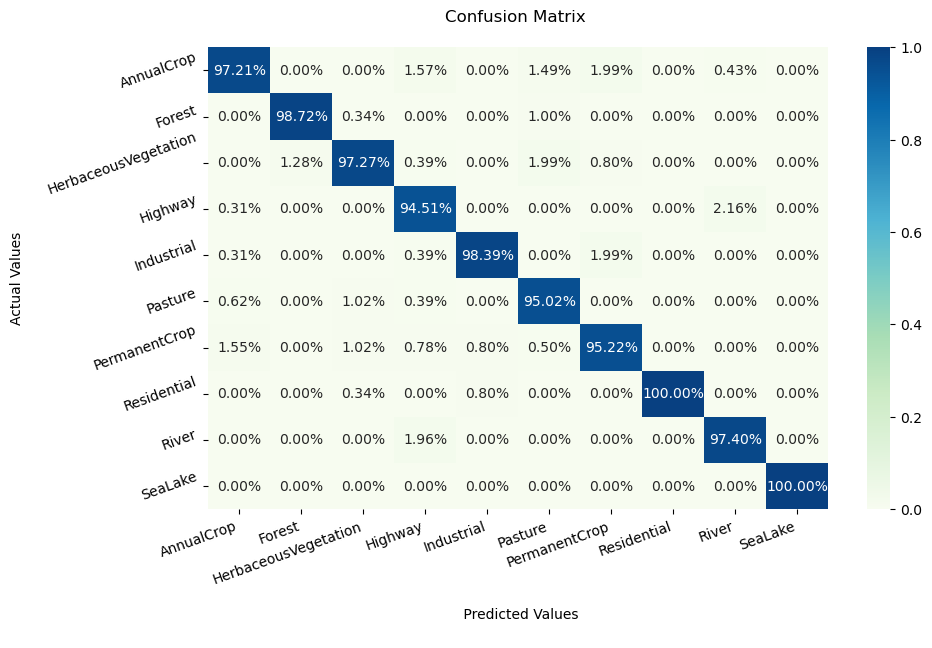

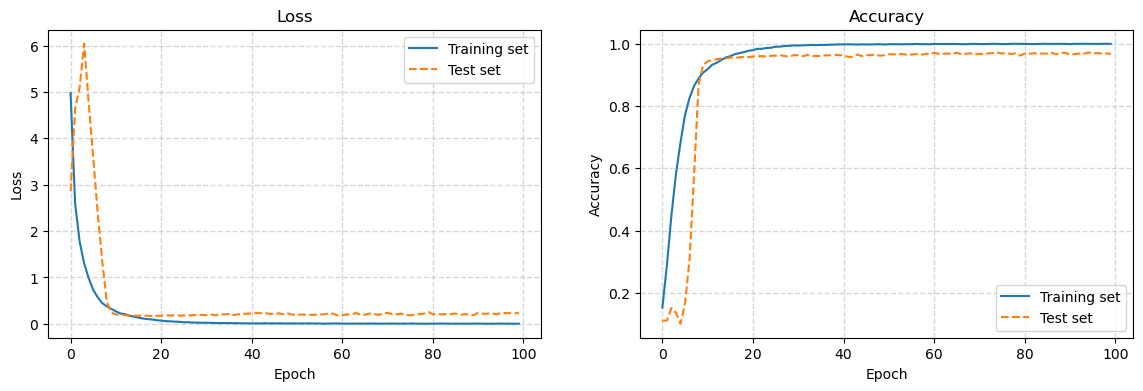

In [12]:
test_loss, test_acc = model.evaluate(ds_test, verbose=0)
print('\nTest accuracy:', test_acc)


ds_test_predict = model.predict(ds_test, verbose=0)

labels_iterator = ds_test.unbatch().map(lambda x, y: y).as_numpy_iterator()
labels = np.array(list(labels_iterator))

y_pred = np.argmax(ds_test_predict, axis=1)
y_test = labels
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_pred, y_test, normalize="pred"), annot=True, fmt=".2%",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['AnnualCrop','Forest','HerbaceousVegetation',
                         'Highway','Industrial','Pasture','PermanentCrop',
                         'Residential','River','SeaLake'], rotation=20, ha="right")
fx.yaxis.set_ticklabels(['AnnualCrop','Forest','HerbaceousVegetation',
                         'Highway','Industrial','Pasture','PermanentCrop',
                         'Residential','River','SeaLake'], rotation=20, ha="right")

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
plt.savefig(fname="resnet50/resnet50 confusion matrix"+current_time,dpi=300)
render_training_history(history)
